In [7]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import re
import pickle

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

#import statsmodels.api as sm
#from patsy import dmatrices
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeavePOut



In [8]:
#define the stats that we want to use
stat_allowed = ['ast', 'blk', 'dreb', 'fga', 'fgm', 'fta', 'ftm', 
                'min', 'oreb', 'to', 'tpa', 'tpm', 'ftper', 'fgper', 
                'tpper', 'pf', 'pts', 'reb', 'stl']
print stat_allowed
stats_to_drop = ['index', 'ha', 'wl', 'game_id', 'team_name']
print stats_to_drop
stats_to_use = ['pts', 'reb', 'dreb', 'oreb', 'to', 'ast', 'fga', 'fgm', 
                'tpa', 'tpm', 
                'fgper', 'ftper', 'tpper', 'stl', 'pf', 'blk', ]
print stats_to_use

#####change this to train or test specific years
the_table = 'teams1516'

['ast', 'blk', 'dreb', 'fga', 'fgm', 'fta', 'ftm', 'min', 'oreb', 'to', 'tpa', 'tpm', 'ftper', 'fgper', 'tpper', 'pf', 'pts', 'reb', 'stl']
['index', 'ha', 'wl', 'game_id', 'team_name']
['pts', 'reb', 'dreb', 'oreb', 'to', 'ast', 'fga', 'fgm', 'tpa', 'tpm', 'fgper', 'ftper', 'tpper', 'stl', 'pf', 'blk']


In [9]:
def calc_full_year(season_sql, season_sql_tags):
    
    full_year = {}
    for season_sql_tag in season_sql_tags:
        print season_sql_tag
    
        if season_sql_tag == 'pts':
            bdict = {'grmin':30.0, 'grmax':100, 'grbins':70, 
                     'grtitle':'Frequency of Total Points Scored', 
                     'grxlab':'Total Points Scored',
                     'cdfmin':0.0, 'cdfmax':130, 'cdfbins':130*5}
        elif season_sql_tag == 'reb':
            bdict = {'grmin':0.0, 'grmax':60, 'grbins':60, 
                     'grtitle':'Frequency of Total Rebounds', 
                     'grxlab':'Total Rebounds',
                     'cdfmin':0.0, 'cdfmax':70, 'cdfbins':70*5}
        elif season_sql_tag == 'oreb':
            bdict = {'grmin':0.0, 'grmax':20, 'grbins':20, 
                     'grtitle':'Frequency of Offensive Rebounds', 
                     'grxlab':'Offensive Rebounds',
                     'cdfmin':0.0, 'cdfmax':30, 'cdfbins':30*5}
        elif season_sql_tag == 'dreb':
            bdict = {'grmin':0.0, 'grmax':40, 'grbins':40, 
                     'grtitle':'Frequency of Defensive Rebounds', 
                     'grxlab':'Defensive Rebounds',
                     'cdfmin':0.0, 'cdfmax':50, 'cdfbins':50*5}
        elif season_sql_tag == 'to':
            bdict = {'grmin':0.0, 'grmax':30, 'grbins':30, 
                     'grtitle':'Frequency of Turnovers', 
                     'grxlab':'Total Turnovers',
                     'cdfmin':0.0, 'cdfmax':40, 'cdfbins':40*5}
        elif season_sql_tag == 'ast':
            bdict = {'grmin':0.0, 'grmax':30, 'grbins':30, 
                     'grtitle':'Frequency of Assists', 
                     'grxlab':'Total Assists',
                     'cdfmin':0.0, 'cdfmax':50, 'cdfbins':50*5}
        elif season_sql_tag == 'fga':
            bdict = {'grmin':30, 'grmax':90, 'grbins':70, 
                     'grtitle':'Frequency of Field Goals Attempted', 
                     'grxlab':'Total Field Goals Attempted',
                     'cdfmin':10.0, 'cdfmax':110, 'cdfbins':100*5}
        elif season_sql_tag == 'fgm':
            bdict = {'grmin':30, 'grmax':90, 'grbins':70, 
                     'grtitle':'Frequency of Field Goals Made', 
                     'grxlab':'Total Field Goals Made',
                     'cdfmin':10.0, 'cdfmax':110, 'cdfbins':100*5}
        elif season_sql_tag == 'fgper':
            bdict = {'grmin':0.0, 'grmax':1.0, 'grbins':100, 
                     'grtitle':'Frequency of Field Goals Percent', 
                     'grxlab':'Total Field Goals Percent',
                     'cdfmin':0.0, 'cdfmax':1.0, 'cdfbins':100*5}
        elif season_sql_tag == 'fta':
            bdict = {'grmin':0, 'grmax':30, 'grbins':30, 
                     'grtitle':'Frequency of Free Throws Attempted', 
                     'grxlab':'Total Free Throws Attempted',
                     'cdfmin':0.0, 'cdfmax':40, 'cdfbins':40*5}
        elif season_sql_tag == 'ftm':
            bdict = {'grmin':0, 'grmax':30, 'grbins':30, 
                     'grtitle':'Frequency of Free Throws Made', 
                     'grxlab':'Total Free Throws Made',
                     'cdfmin':0.0, 'cdfmax':30, 'cdfbins':30*5}
        elif season_sql_tag == 'ftper':
            bdict = {'grmin':0.0, 'grmax':1.0, 'grbins':100, 
                     'grtitle':'Frequency of Free Throw Percent', 
                     'grxlab':'Total Free Throw Percent',
                     'cdfmin':0.0, 'cdfmax':1.0, 'cdfbins':100*5}
        elif season_sql_tag == 'tpa':
            bdict = {'grmin':0.0, 'grmax':30, 'grbins':30, 
                     'grtitle':'Frequency of Three Pointers Attempted', 
                     'grxlab':'Total Three Pointers Attempted',
                     'cdfmin':0.0, 'cdfmax':40, 'cdfbins':30*5}
        elif season_sql_tag == 'tpm':
            bdict = {'grmin':0, 'grmax':20, 'grbins':20, 
                     'grtitle':'Frequency of Three Pointers Made', 
                     'grxlab':'Total Three Pointers Made',
                     'cdfmin':0.0, 'cdfmax':20, 'cdfbins':20*5}
        elif season_sql_tag == 'tpper':
            bdict = {'grmin':0.0, 'grmax':1.0, 'grbins':100, 
                     'grtitle':'Frequency of Three Pointer Percent', 
                     'grxlab':'Total Three Pointer Percent',
                     'cdfmin':0.0, 'cdfmax':1.0, 'cdfbins':100*5}
        elif season_sql_tag == 'stl':
            bdict = {'grmin':0, 'grmax':20, 'grbins':20, 
                     'grtitle':'Frequency of Steals', 
                     'grxlab':'Total Steals',
                     'cdfmin':0.0, 'cdfmax':30, 'cdfbins':30*5}
        elif season_sql_tag == 'pf':
            bdict = {'grmin':10, 'grmax':30, 'grbins':20, 
                     'grtitle':'Frequency of Personal Fouls', 
                     'grxlab':'Total Personal Fouls',
                     'cdfmin':0.0, 'cdfmax':50, 'cdfbins':250*5}
        else:
            bdict = {'grmin':0.0, 'grmax':50, 'grbins':50, 
                     'grtitle':'Frequency of Variable', 
                     'grxlab':'Variable',
                     'cdfmin':0.0, 'cdfmax':50, 'cdfbins':50*5}
 
        #calculate some bin arrays and add them 
        bins = ((bdict['grmax']-bdict['grmin']) / bdict['grbins']) 
        bins = bins * np.arange(bdict['grbins']+1) + bdict['grmin'] 
        bdict['bins'] = bins
        cdf_bins = ((bdict['cdfmax']-bdict['cdfmin']) / bdict['cdfbins']) 
        cdf_bins = cdf_bins * np.arange(bdict['cdfbins']+1) + bdict['cdfmin'] 
        bdict['cdf_bins'] = cdf_bins
        
        #fit some lognormal functions and add those parameters
        cur_samp = list(season_sql.loc[:,season_sql_tag])
        param = sp.stats.lognorm.fit(cur_samp) # fit the sample data
        bdict['param'] = param



        full_year[season_sql_tag] = bdict
    
    return full_year

In [10]:
#team1 = 'Wisconsin Badgers'
#team2 = 'Arizona Wildcats'

username = 'smaug'
dbname = 'ncaa_mbb_db'


con = None
con = psycopg2.connect(database=dbname, user=username)


###for the parameters requested get the full year statistics summaries and fits
sql_cols = ''
for ii in np.arange(len(stats_to_use)):
    if ii == 0:
        sql_cols = sql_cols + '"' + stats_to_use[ii] + '"'
    else:
        sql_cols = sql_cols + ', "' + stats_to_use[ii] + '"'

sql_query = '''
            SELECT %s 
             FROM %s LEFT JOIN %s ON (%s.wl=%s.wl)
            ''' % (sql_cols, the_table, 'winloss', the_table, 'winloss')
print sql_query
try:
    season_sql = pd.read_sql_query(sql_query, con)
    season_sql_tags = list(season_sql.columns.values)
except:
    print '  team1 stats not obtained'
print season_sql.head(8)
full_year_stats = calc_full_year(season_sql, season_sql_tags)
#print full_year_stats


### get all unique game ids and dates of those games
sql_query = '''
            SELECT DISTINCT(game_id), date
             FROM %s LEFT JOIN %s ON (CAST(%s.game_id as INT) = CAST(%s.id as INT)) 
            ''' % (the_table, 'games', the_table, 'games')
print sql_query
#try:
game_dates = pd.read_sql_query(sql_query, con)
#except:
#    print '  team stats table, %s, does not exist' % (the_table)
print game_dates.tail(8)

    




            SELECT "pts", "reb", "dreb", "oreb", "to", "ast", "fga", "fgm", "tpa", "tpm", "fgper", "ftper", "tpper", "stl", "pf", "blk" 
             FROM teams1516 LEFT JOIN winloss ON (teams1516.wl=winloss.wl)
            
   pts  reb  dreb  oreb  to  ast  fga  fgm  tpa  tpm     fgper     ftper  \
0   79   26    20     6  12   23   72   29   33   10  0.402778  0.687500   
1   78   38    26    12  15   14   65   30   39   13  0.461538  0.416667   
2   68   35    23    12  13   13   68   26   30    8  0.382353  0.533333   
3   63   18    16     2  20    5   47   22   15    5  0.468085  0.823529   
4   57   31    21    10  20    9   52   15   19    5  0.288462  0.687500   
5   69   29    22     7  13   11   53   24   19    4  0.452830  0.653846   
6   60   19    16     3  15   14   46   18   20    9  0.391304  0.681818   
7   57   33    19    14   9    8   64   20   21    3  0.312500  0.736842   

      tpper  stl  pf  blk  
0  0.303030    9  20    3  
1  0.333333    5  21    2  
2  0.

In [5]:
def sample_plots(cur_samp, bins, bdict, pdf_fitted, first, second):

    #print bins
    n, bins, patches = plt.hist(cur_samp, bins, normed=1, facecolor='green', alpha=0.30)
    plt.title(bdict['grtitle'])
    plt.xlabel(bdict['grxlab'])
    plt.ylabel('Frequency')
    plt.grid(True)


    plt.plot(bins,pdf_fitted, 'r-', linewidth=2)
    plt.axvline(first, color='blue', linewidth=2, label='First Team')
    plt.axvline(second, color='yellow', linewidth=2, label='Second Team')

    plt.legend()
    plt.show()


  Now working on game id 400809203 on date 2015-11-17
    Team 1: Duke Blue Devils
    Team 2: Kentucky Wildcats
  Now working on game id 400809204 on date 2015-11-17
    Team 1: Kansas Jayhawks
    Team 2: Michigan State Spartans
  Now working on game id 400809205 on date 2015-12-08
    Team 1: Virginia Cavaliers
    Team 2: West Virginia Mountaineers
  Now working on game id 400809206 on date 2015-12-08
    Team 1: Connecticut Huskies
    Team 2: Maryland Terrapins
  Now working on game id 400809209 on date 2015-11-19
    Team 1: Houston Baptist Huskies
    Team 2: TCU Horned Frogs
  Now working on game id 400809210 on date 2015-11-19
    Team 1: Illinois State Redbirds
    Team 2: South Dakota State Jackrabbits
  Now working on game id 400809211 on date 2015-11-21
    Team 1: Cleveland State Vikings
    Team 2: Rhode Island Rams
  Now working on game id 400809212 on date 2015-11-24
    Team 1: Houston Baptist Huskies
    Team 2: South Dakota State Jackrabbits
  Now working on game i

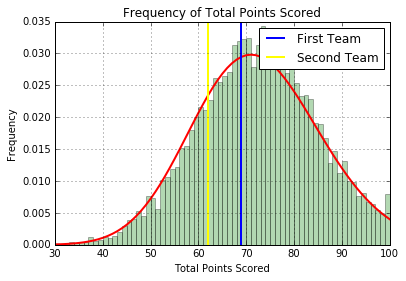

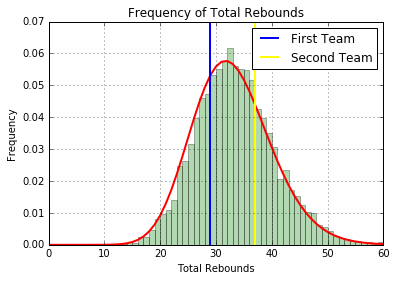

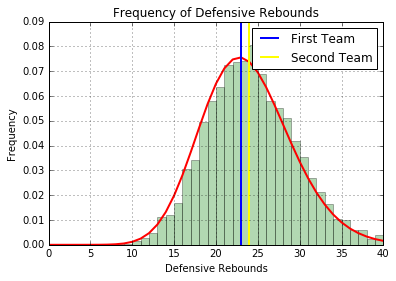

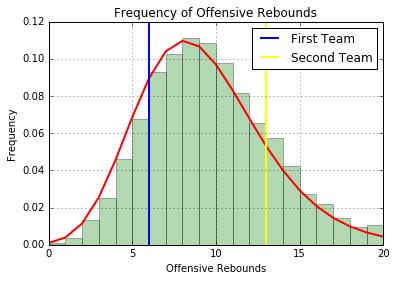

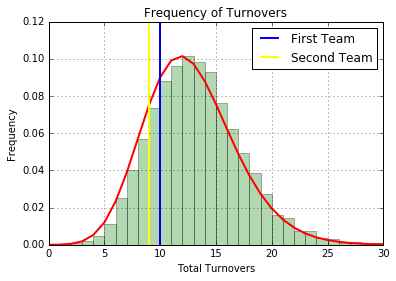

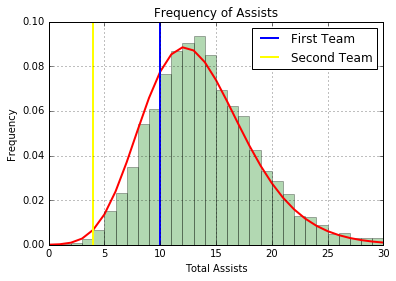

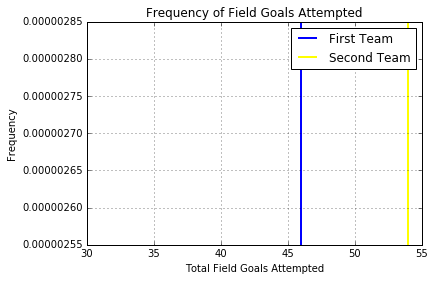

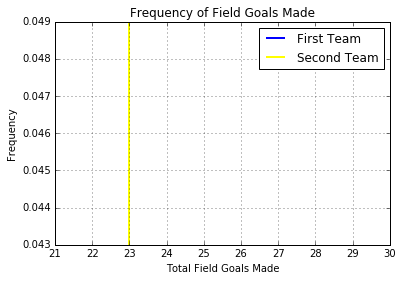

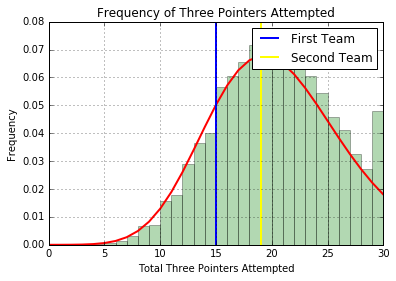

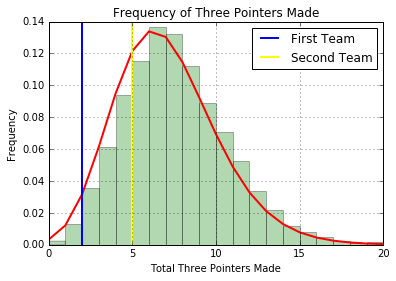

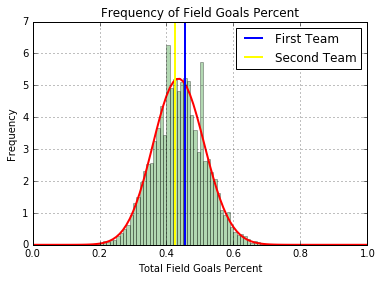

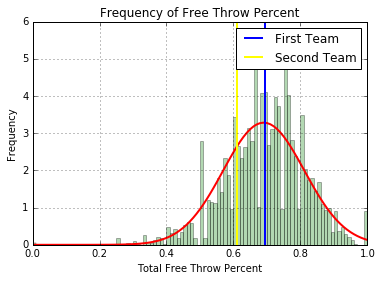

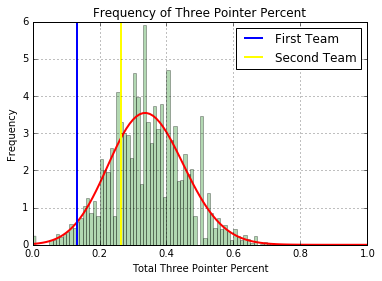

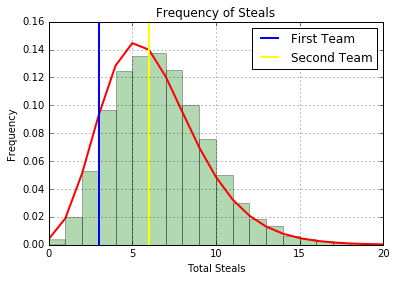

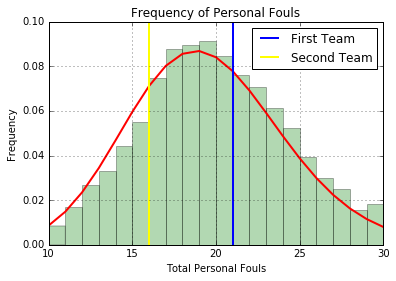

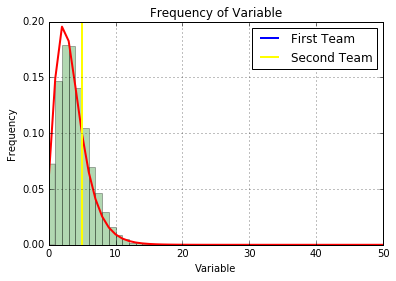

  Now working on game id 400809394 on date 2015-11-17
    Team 1: Nebraska Cornhuskers
    Team 2: Villanova Wildcats
  Now working on game id 400809395 on date 2015-11-18
    Team 1: Illinois Fighting Illini
    Team 2: Providence Friars
  Now working on game id 400809396 on date 2015-11-19
    Team 1: Creighton Bluejays
    Team 2: Indiana Hoosiers
  Now working on game id 400809397 on date 2015-11-19
    Team 1: Iowa Hawkeyes
    Team 2: Marquette Golden Eagles
  Now working on game id 400809398 on date 2015-11-19
    Team 1: Rutgers Scarlet Knights
    Team 2: St John''s Red Storm
  Now working on game id 400809399 on date 2015-11-20
    Team 1: Michigan Wolverines
    Team 2: Xavier Musketeers
  Now working on game id 400809400 on date 2015-11-30
    Team 1: Clemson Tigers
    Team 2: Minnesota Golden Gophers
  Now working on game id 400809401 on date 2015-11-30
    Team 1: Rutgers Scarlet Knights
    Team 2: Wake Forest Demon Deacons
  Now working on game id 400809402 on date 201

In [6]:
cnt = 0
XS = []
ys = []


for ii in game_dates.loc[:,'game_id']:
    print '  Now working on game id %s on date %s' % (game_dates.loc[cnt,'game_id'], game_dates.loc[cnt,'date'])
    
    sql_query = '''
                SELECT team_name
                 FROM %s
                 WHERE game_id IN ('%s');
                ''' % (the_table, game_dates.loc[cnt,'game_id'])
    #print sql_query
    teams_name = pd.read_sql_query(sql_query, con)
    team1_name = teams_name.iloc[0,0]
    match  = re.search('\'', team1_name)
    if match is not None:
        team1_name = team1_name.replace("'", "''")
    print '    Team 1:', team1_name
    team2_name = teams_name.iloc[1,0]
    match  = re.search('\'', team2_name)
    if match is not None:
        team2_name = team2_name.replace("'", "''")
    print '    Team 2:', team2_name

    
    new_sql_cols = sql_cols + ', "date", "wl_int"'    
    sql_query = '''
                SELECT %s
                 FROM %s LEFT JOIN %s ON (CAST(%s.game_id as INT) = CAST(%s.id as INT)) 
                         LEFT JOIN %s ON (%s.wl=%s.wl)
                 WHERE team_name IN ('%s')
                 ORDER BY date DESC;
                ''' % (new_sql_cols, the_table, 'games', the_table, 
                       'games', 'winloss', the_table, 'winloss', team1_name)
    #print sql_query
    #try:
    team1_sql = pd.read_sql_query(sql_query, con)
    team1_ngames = len(team1_sql.iloc[:,0])

    #except:
    #    print '  team stats table, %s, does not exist' % (the_table)
    date_compare = (game_dates.loc[cnt,'date'] == team1_sql['date']) 
    date_ind = date_compare[date_compare == True]
    this_ind = (team1_ngames - 1) - date_ind.index[0] 
    if this_ind == 0:
        print '      First game of season; model can not cope!!'
        team1_use = None
    elif this_ind < 5:
        #print date_ind.index[0], team1_ngames - 1
        team1_use = team1_sql.iloc[date_ind.index[0]+1:]
    else:
        #print date_ind.index[0], date_ind.index[0] + 5
        team1_use = team1_sql.iloc[date_ind.index[0]+1:date_ind.index[0] + 6]

    the_label = team1_sql.loc[date_ind.index[0],'wl_int']
    
    
    sql_query = '''
                SELECT %s
                 FROM %s LEFT JOIN %s ON (CAST(%s.game_id as INT) = CAST(%s.id as INT)) 
                         LEFT JOIN %s ON (%s.wl=%s.wl)
                 WHERE team_name IN ('%s')
                 ORDER BY date DESC;
                ''' % (new_sql_cols, the_table, 'games', the_table, 
                       'games', 'winloss', the_table, 'winloss', team2_name)
    #print sql_query
    #try:
    team2_sql = pd.read_sql_query(sql_query, con)
    team2_ngames = len(team2_sql.iloc[:,0])

    #except:
    #    print '  team stats table, %s, does not exist' % (the_table)
    date_compare = (game_dates.loc[cnt,'date'] == team2_sql['date']) 
    date_ind = date_compare[date_compare == True]
    this_ind = (team2_ngames - 1) - date_ind.index[0] 
    if this_ind == 0:
        print '      First game of season; model can not cope!!'
        team2_use = None
    elif this_ind < 5:
        #print date_ind.index[0], team1_ngames - 1
        team2_use = team2_sql.iloc[date_ind.index[0]+1:]
    else:
        #print date_ind.index[0], date_ind.index[0] + 5
        team2_use = team2_sql.iloc[date_ind.index[0]+1:date_ind.index[0] + 6]

    the_label_chk = team2_sql.loc[date_ind.index[0],'wl_int']
    
    #a sanity check: someone has to win and someone has to lose
    if (the_label + the_label_chk) !=0:
        print 'WARNING!!!!! The win/loss labels dont sum to zero!!!!!!'


    
    if team1_use is not None and team2_use is not None:
        #find mean of last 5 games
        team1_use = team1_use.mean()
        team2_use = team2_use.mean()        

        #find percentile differential
        XS_entry = []
        ys.append(the_label)
        for season_sql_tag in season_sql_tags:

            #grab values
            bdict = full_year_stats[season_sql_tag]
            cur_samp = list(season_sql.loc[:,season_sql_tag])

            #grab more values
            bins = bdict['bins']
            cdf_bins = bdict['cdf_bins']
            param = bdict['param']

            #calculate the fitted PDF
            pdf_fitted = sp.stats.lognorm.pdf(bins, param[0], loc=param[1], scale=param[2]) # fitted distribution
            cdf_fitted = sp.stats.lognorm.cdf(cdf_bins, param[0], loc=param[1], scale=param[2]) # fitted distribution


            #find the percentile difference using the CDF
            #print team1_use[season_sql_tag], team2_use[season_sql_tag]
            cdf_diff = [abs(team1_use[season_sql_tag]-ii) for ii in cdf_bins]
            cdf_min_ind = cdf_diff.index(min(cdf_diff))
            first = cdf_fitted[cdf_min_ind]
            cdf_diff = [abs(team2_use[season_sql_tag]-ii) for ii in cdf_bins]
            cdf_min_ind = cdf_diff.index(min(cdf_diff))
            second = cdf_fitted[cdf_min_ind]
            #print first, second, first - second
            XS_entry.append(first - second)

            #make sample plots
            if cnt == 48:
                chk = sample_plots(cur_samp, bins, bdict, pdf_fitted, 
                                   team1_use[season_sql_tag], team2_use[season_sql_tag])
            
        XS.append(XS_entry)
    #if cnt >=48:
    #    sys.exit(0)
    cnt = cnt + 1

In [38]:
print XS[0:2]
print ys[0:2]
print len(ys)

#save_thing = pd.DataFrame(XS, columns=season_sql_tags)
#save_thing['wl_int'] = ys
#save_thing.to_csv('diff_5game_ave_1415.csv')
#target = open('diff_1415')

[[0.20891441762504159, 0.0086426046971237458, -0.06412411556016484, 0.031425349941118785, -0.74339155640651344, -0.16272995283306718, 0.34431885087340586, 0.13301303577627677, 0.38673525816936133, 0.47441222391894, -0.064017466814811019, 0.1008608933594769, 0.25760417602780078, 0.42000414609517289, -0.2518698017724168, -0.13882439040264849], [0.22995921535548836, -0.40427436219936397, -0.20703783375882945, -0.66776461565063561, 0.17485531129390897, 0.0088478340312987402, -0.045234133784811892, 0.12580061371619522, 0.72030808579644034, 0.72326506334778706, 0.21089310856829757, 0.47886738019180342, 0.32861637563902157, 0.63069459089819857, 0.72288267653131311, -0.33038440477096032]]
[-1, -1]
3678


## Run this section only to test a final model on the current season
#### select the model that you wish to check with, load that pickle and evaluate the season. 

In [43]:
model = 'models/model_logreg_16feature_1415.p'
my_model_again = pickle.load(open(model, "r" ) )
#print my_model_again.coef_
model = my_model_again.fit(XS, ys)
print '  The models score is: ', my_model_again.score(XS, ys)
print '  The average value of the y-label is: ', np.mean(ys)


model = 'models/model_rfc2_16feature_1415.p'
my_model_again = pickle.load(open(model, "r" ) )
predicted = my_model_again.predict(XS)
#print '  The label that the model predicts:', predicted
probs = my_model_again.predict_proba(XS)
#print '  The probability that the model predicts:', probs
#print ''
print '  Model score:',  my_model_again.score(XS, ys)
print '  Model accuracy score:', metrics.accuracy_score(ys, predicted)
print '  Model AUC score:', metrics.roc_auc_score(ys, probs[:, 1])



   The models score is:  0.675095160413
  The average value of the y-label is:  -0.0483958673192
  Model score: 0.651169113649
  Model accuracy score: 0.651169113649
  Model AUC score: 0.701530379372


##### end section of final testing on this year's games

# now we do the actual logistic regression fitting

In [10]:
#just a basic logistic regression on all the data together
model = LogisticRegression()
#print model

model = model.fit(XS, ys)
print '  The models score is: ', model.score(XS, ys)
print '  The average value of the y-label is: ', np.mean(ys)

pd.DataFrame(zip(season_sql_tags, np.transpose(model.coef_)))

  The models score is:  0.663261583364
  The average value of the y-label is:  -0.051076249544


,0,1
0,pts,[-0.00822786461291]
1,reb,[0.914353336705]
2,dreb,[0.232071534802]
3,oreb,[0.734345944806]
4,to,[-1.68563875925]
5,ast,[0.5249470469]
6,fga,[-1.14124846633]
7,fgm,[0.248597459997]
8,tpa,[0.369313784701]
9,tpm,[-0.144933934587]


In [11]:
#now with a testing and a training set
XS_train, XS_test, ys_train, ys_test = train_test_split(XS, ys, test_size=0.3, random_state=0)
#print len(XS_train), len(XS_test)
#print len(ys_train), len(ys_test)

model2 = LogisticRegression()
model2.fit(XS_train, ys_train)
print pd.DataFrame(zip(season_sql_tags, np.transpose(model.coef_), np.transpose(model2.coef_)))

predicted = model2.predict(XS_test)
print '  The label that the model predicts:', predicted
probs = model2.predict_proba(XS_test)
print '  The probability that the model predicts:', probs
print ''
print model.score(XS_test, ys_test)
print metrics.accuracy_score(ys_test, predicted)
print metrics.roc_auc_score(ys_test, probs[:, 1])
print '  Confusion matrix'
print metrics.confusion_matrix(ys_test, predicted)
print '  Classification report'
print metrics.classification_report(ys_test, predicted)


        0                    1                  2
0     pts  [-0.00822786461291]  [0.0434204680509]
1     reb     [0.914353336705]   [0.784732184481]
2    dreb     [0.232071534802]   [0.480583280619]
3    oreb     [0.734345944806]   [0.885801089678]
4      to     [-1.68563875925]   [-1.71281714952]
5     ast       [0.5249470469]   [0.651285001737]
6     fga     [-1.14124846633]   [-1.07453105069]
7     fgm     [0.248597459997]    [-0.0156673396]
8     tpa     [0.369313784701]    [0.44462919269]
9     tpm    [-0.144933934587]  [-0.355296217893]
10  fgper      [1.18779924289]    [1.20288482106]
11  ftper     [0.353949974923]   [0.373113706094]
12  tpper    [0.0104150625493]   [0.206374803114]
13    stl     [0.799333382692]   [0.708521204727]
14     pf    [-0.398377804487]  [-0.369331867832]
15    blk      [0.54726993308]   [0.548460127602]
  The label that the model predicts: [-1 -1 -1 ..., -1 -1  1]
  The probability that the model predicts: [[ 0.67567584  0.32432416]
 [ 0.57298094  0.4

In [14]:
#now with a 10 fold cross validation
scores = cross_val_score(LogisticRegression(), XS, ys, scoring='accuracy', cv=10)
print scores
print '    Average score:', scores.mean()
print '    Std Dev of score:', scores.std()
print '    Minimum score:', scores.min()
print '    Maximum score:', scores.max()




[ 0.63454545  0.6459854   0.65510949  0.68248175  0.66970803  0.67518248
  0.68065693  0.67153285  0.68065693  0.62226277]
    Average score: 0.661812209688
    Std Dev of score: 0.0201894138916
    Minimum score: 0.622262773723
    Maximum score: 0.682481751825


In [28]:
print model2.coef_
pickle.dump(model2, open( "model_logreg_16feature_1415.p", "w" ) )
#my_model_again = pickle.load(open( "saved_model.p", "r" ) )
#print my_model_again.coef_

[[ 0.04342047  0.78473218  0.48058328  0.88580109 -1.71281715  0.651285
  -1.07453105 -0.01566734  0.44462919 -0.35529622  1.20288482  0.37311371
   0.2063748   0.7085212  -0.36933187  0.54846013]]


In [20]:
npoints = len(ys)
print npoints

score = []
acc_score = []
roc_auc = []
kf = KFold(npoints, n_folds=50, shuffle=True)
print kf
for train, test in kf:

    XS_train = []
    ys_train = []
    for ii in train:
        XS_train.append(XS[ii])
        ys_train.append(ys[ii])

    XS_test = []
    ys_test = []
    for ii in test:
        XS_test.append(XS[ii])
        ys_test.append(ys[ii])

        
    model = LogisticRegression()
    model.fit(XS_train, ys_train)
    #print pd.DataFrame(zip(season_sql_tags, np.transpose(model.coef_)))
    predicted = model.predict(XS_test)
    probs = model.predict_proba(XS_test)
    score.append(model.score(XS_test, ys_test))
    acc_score.append(metrics.accuracy_score(ys_test, predicted))
    roc_auc.append(metrics.roc_auc_score(ys_test, probs[:, 1]))
    #print '  Classification report'
    #print metrics.classification_report(ys_test, predicted)


#print score
print '    Average score:', np.mean(score)
print '    Std Dev of score:', np.std(score)
print '    Minimum score:', np.min(score)
print '    Maximum score:', np.max(score)
print ''

#print acc_score
print '    Average score:', np.mean(acc_score)
print '    Std Dev of score:', np.std(acc_score)
print '    Minimum score:', np.min(acc_score)
print '    Maximum score:', np.max(acc_score)
print ''

#print roc_auc
print '    Average score:', np.mean(roc_auc)
print '    Std Dev of score:', np.std(roc_auc)
print '    Minimum score:', np.min(roc_auc)
print '    Maximum score:', np.max(roc_auc)
print ''




5482
sklearn.cross_validation.KFold(n=5482, n_folds=50, shuffle=True, random_state=None)
    Average score: 0.661039199333
    Std Dev of score: 0.0425408196576
    Minimum score: 0.587155963303
    Maximum score: 0.763636363636

    Average score: 0.661039199333
    Std Dev of score: 0.0425408196576
    Minimum score: 0.587155963303
    Maximum score: 0.763636363636

    Average score: 0.713241256135
    Std Dev of score: 0.0501424397398
    Minimum score: 0.557354925776
    Maximum score: 0.793951478897



# now we do random forest

In [21]:
#ntrees = [10,20,30,40,50,70,90,110,130,150,200,250,300,350,400,450,500]
ntrees = [20,50,110,250,500,1000]

In [22]:
for ntree in ntrees:
    model = RandomForestClassifier(n_estimators=ntree, oob_score=True)
    #print model

    model = model.fit(XS, ys)
    print '  The models score is: ', model.score(XS, ys)
print '  The average value of the y-label is: ', np.mean(ys)

  The models score is:  0.998540678584
  The models score is:  1.0
  The models score is:  1.0
  The models score is:  1.0
  The models score is:  1.0
  The models score is:  1.0
  The average value of the y-label is:  -0.051076249544


//anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:379: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [23]:
print len(ys)
print len(XS)

#now with a testing and a training set
XS_train, XS_test, ys_train, ys_test = train_test_split(XS, ys, test_size=0.3, random_state=0)
#print len(XS_train), len(XS_test)
#print len(ys_train), len(ys_test)

for ntree in ntrees:
    print '  Number of trees: ', ntree
    model_rfc2 = RandomForestClassifier(n_estimators=ntree, oob_score=True)
    model_rfc2.fit(XS_train, ys_train)

    predicted = model_rfc2.predict(XS_test)
    #print '  The label that the model predicts:', predicted
    probs = model_rfc2.predict_proba(XS_test)
    #print '  The probability that the model predicts:', probs
    #print ''
    print '  Model score:',  model_rfc2.score(XS_test, ys_test)
    print '  Model accuracy score:', metrics.accuracy_score(ys_test, predicted)
    print '  Model AUC score:', metrics.roc_auc_score(ys_test, probs[:, 1])
    #print '  Confusion matrix'
    #print metrics.confusion_matrix(ys_test, predicted)
    #print '  Classification report'
    #print metrics.classification_report(ys_test, predicted)
    #print ''


5482
5482
  Number of trees:  20
  Model score: 0.624924012158
  Model accuracy score: 0.624924012158
  Model AUC score: 0.666072837156
  Number of trees:  50
  Model score: 0.641337386018
  Model accuracy score: 0.641337386018
  Model AUC score: 0.684089372453
  Number of trees:  110
  Model score: 0.63282674772
  Model accuracy score: 0.63282674772
  Model AUC score: 0.676172387002
  Number of trees:  250
  Model score: 0.642553191489
  Model accuracy score: 0.642553191489
  Model AUC score: 0.690208559448
  Number of trees:  500
  Model score: 0.640121580547
  Model accuracy score: 0.640121580547
  Model AUC score: 0.692190956592
  Number of trees:  1000
  Model score: 0.652279635258
  Model accuracy score: 0.652279635258
  Model AUC score: 0.691840293223


In [26]:
#make sure you change the name accordingly
pickle.dump(model_rfc2, open( "model_rfc2_16feature_1415.p", "w" ) )



In [24]:
#now with a 10 fold cross validation
scores_rfc = cross_val_score(RandomForestClassifier(n_estimators=250, oob_score=True),
                         XS, ys, scoring='accuracy', cv=10)

print scores
print '    Average score:', np.mean(scores_rfc)
print '    Std Dev of score:', np.std(scores_rfc)
print '    Minimum score:', np.min(scores_rfc)
print '    Maximum score:', np.max(scores_rfc)




[ 0.63454545  0.6459854   0.65510949  0.68248175  0.66970803  0.67518248
  0.68065693  0.67153285  0.68065693  0.62226277]
    Average score: 0.640640345056
    Std Dev of score: 0.0165575307239
    Minimum score: 0.598540145985
    Maximum score: 0.658759124088


In [25]:
npoints = len(ys)
print npoints

score = []
acc_score = []
roc_auc = []
kf = KFold(npoints, n_folds=50)
cnt = 0
for train, test in kf:
    print cnt
    cnt = cnt + 1

    XS_train = []
    ys_train = []
    for ii in train:
        XS_train.append(XS[ii])
        ys_train.append(ys[ii])

    XS_test = []
    ys_test = []
    for ii in test:
        XS_test.append(XS[ii])
        ys_test.append(ys[ii])

        
    model_rfc3 = RandomForestClassifier(n_estimators=250, oob_score=True)
    model_rfc3.fit(XS_train, ys_train)
    predicted = model_rfc3.predict(XS_test)
    probs = model_rfc3.predict_proba(XS_test)
    score.append(model_rfc3.score(XS_test, ys_test))
    acc_score.append(metrics.accuracy_score(ys_test, predicted))
    roc_auc.append(metrics.roc_auc_score(ys_test, probs[:, 1]))
    #print '  Classification report'
    #print metrics.classification_report(ys_test, predicted)


print score
print '    Average score:', np.mean(score)
print '    Std Dev of score:', np.std(score)
print '    Minimum score:', np.min(score)
print '    Maximum score:', np.max(score)

print acc_score
print '    Average score:', np.mean(acc_score)
print '    Std Dev of score:', np.std(acc_score)
print '    Minimum score:', np.min(acc_score)
print '    Maximum score:', np.max(acc_score)

print roc_auc
print '    Average score:', np.mean(roc_auc)
print '    Std Dev of score:', np.std(roc_auc)
print '    Minimum score:', np.min(roc_auc)
print '    Maximum score:', np.max(roc_auc)




5482
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[0.73636363636363633, 0.65454545454545454, 0.62727272727272732, 0.63636363636363635, 0.66363636363636369, 0.60909090909090913, 0.67272727272727273, 0.59999999999999998, 0.63636363636363635, 0.65454545454545454, 0.54545454545454541, 0.60909090909090913, 0.67272727272727273, 0.63636363636363635, 0.65454545454545454, 0.72727272727272729, 0.63636363636363635, 0.59999999999999998, 0.70909090909090911, 0.67272727272727273, 0.53636363636363638, 0.69090909090909092, 0.71818181818181814, 0.69090909090909092, 0.60909090909090913, 0.59090909090909094, 0.66363636363636369, 0.6454545454545455, 0.70909090909090911, 0.62727272727272732, 0.59999999999999998, 0.63636363636363635, 0.60550458715596334, 0.6330275229357798, 0.77981651376146788, 0.69724770642201839, 0.61467889908256879, 0.61467889908256879, 0.66972477064220182, 0.74311926605504586, 0.69724770642201